# Capture Wikipedia polling data and produce LOWESS charts

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-set-up" data-toc-modified-id="Python-set-up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python set-up</a></span></li><li><span><a href="#Get-Wikipedia-polling-data" data-toc-modified-id="Get-Wikipedia-polling-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get Wikipedia polling data</a></span></li><li><span><a href="#Data-cleaning" data-toc-modified-id="Data-cleaning-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data cleaning</a></span></li><li><span><a href="#Data-quality-checks" data-toc-modified-id="Data-quality-checks-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data quality checks</a></span></li><li><span><a href="#Attribute-undecideds-(and-force-polls-to-sum-to-100-percent)" data-toc-modified-id="Attribute-undecideds-(and-force-polls-to-sum-to-100-percent)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Attribute undecideds (and force polls to sum to 100 percent)</a></span></li><li><span><a href="#Calculate-2pp-based-on-preference-flows-at-the-2019-election" data-toc-modified-id="Calculate-2pp-based-on-preference-flows-at-the-2019-election-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Calculate 2pp based on preference flows at the 2019 election</a></span></li><li><span><a href="#Quick-plots" data-toc-modified-id="Quick-plots-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Quick plots</a></span><ul class="toc-item"><li><span><a href="#Plotting-constants" data-toc-modified-id="Plotting-constants-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Plotting constants</a></span></li><li><span><a href="#Plots-with-summary-lines-by-individual-pollsters" data-toc-modified-id="Plots-with-summary-lines-by-individual-pollsters-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Plots with summary lines by individual pollsters</a></span></li><li><span><a href="#All-poll-aggregations" data-toc-modified-id="All-poll-aggregations-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>All poll aggregations</a></span></li><li><span><a href="#Preferred-Prime-Minister" data-toc-modified-id="Preferred-Prime-Minister-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>Preferred Prime Minister</a></span></li><li><span><a href="#Satisfaction-charts" data-toc-modified-id="Satisfaction-charts-7.5"><span class="toc-item-num">7.5&nbsp;&nbsp;</span>Satisfaction charts</a></span></li></ul></li><li><span><a href="#Save-files" data-toc-modified-id="Save-files-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Save files</a></span></li><li><span><a href="#Check-for-any-problems-with-data-capture-and-cleaning" data-toc-modified-id="Check-for-any-problems-with-data-capture-and-cleaning-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Check for any problems with data capture and cleaning</a></span></li></ul></div>

## Python set-up

In [1]:
# data science imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm

# standard python imports
import platform, sys, os, pathlib
from io import StringIO
from typing import List

# local imports
import common
from common import COLOR_COALITION, COLOR_LABOR, COLOR_OTHER, COLOR_GREEN
from common import P_COLOR_COALITION, P_COLOR_LABOR, P_COLOR_OTHER, P_COLOR_GREEN

In [2]:
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Fri Jan 21 2022 10:17:48

Python implementation: CPython
Python version       : 3.9.9
IPython version      : 8.0.1

platform   : 1.0.8
matplotlib : 3.5.1
statsmodels: 0.13.1
numpy      : 1.22.0
sys        : 3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:38:53) 
[Clang 11.1.0 ]
pandas     : 1.3.5

Watermark: 2.3.0



In [3]:
# pandas 
pd.set_option('display.max_rows', 1000)

In [4]:
# plotting stuff
plt.style.use('./markgraph.mplstyle')
LFOOTER = 'Polling data from Wikipedia'

In [5]:
# saving downloaded files
DATA_DIR = '../data'
pathlib.Path(DATA_DIR).mkdir(parents=True, exist_ok=True)
DATA_DIR += '/'

## Get Wikipedia polling data

In [6]:
WIKIURL = (
    'https://en.wikipedia.org/wiki/'
    'Opinion_polling_for_the_next_Australian_federal_election'
)
text = common.get_url_text(WIKIURL)

In [7]:
def extract_polling_tables(text):
    sought = {
        # description:              table number in wiki page
        "Voting intention":         0,
        "Preferred prime minister": 1,
    }

    table_dict = {}
    for item, table_number in sought.items():
        table_dict[item] = common.get_table_from_text(table_number, text)
  
    return table_dict

table_dict = extract_polling_tables(text)

In [8]:
# Web scraping is always a little fragile
# we check the tables extracted here:

for key, table in table_dict.items():
    print(key)
    display(table.iloc[:3])
    print('=' * 40)

Voting intention


Date                 Brand  \
                    Unnamed: 0_level_1    Unnamed: 1_level_1   
0                    4–16 January 2022         Roy Morgan[1]   
1                   11–15 January 2022  Resolve Strategic[2]   
2  11–12 December, 18–19 December 2021         Roy Morgan[3]   

      Interview mode        Sample size Primary vote                         \
  Unnamed: 2_level_1 Unnamed: 3_level_1         L/NP  ALP    GRN ONP    OTH   
0   Telephone/Online               2791        34.5%  37%    12%  3%  13.5%   
1             Online               1607          34%  35%    11%  3%    17%   
2   Telephone/Online                NaN        34.5%  37%  11.5%  4%    13%   

       2pp vote              
   UND     L/NP    ALP  UND  
0  NaN      44%    56%  NaN  
1  NaN      NaN    NaN  NaN  
2  NaN    45.5%  55.5%  NaN

Preferred prime minister


Date              Brand               Firm  \
    Unnamed: 0_level_1 Unnamed: 1_level_1 Unnamed: 2_level_1   
0    1–4 December 2021        Newspoll[5]             YouGov   
1  10–13 November 2021       Newspoll[10]             YouGov   
2   20–23 October 2021       Newspoll[20]             YouGov   

      Interview mode        Sample size Preferred Prime Minister           \
  Unnamed: 3_level_1 Unnamed: 4_level_1                 Morrison Albanese   
0             Online                NaN                      45%      36%   
1             Online                NaN                      46%      38%   
2             Online                NaN                      48%      34%   

              Morrison                          Albanese               \
  Don't Know Satisfied Dissatisfied Don't Know Satisfied Dissatisfied   
0        19%       44%          52%         4%       39%          45%   
1        16%       44%          52%         4%       37%          48%   
2        18%       46%          50%         4%       37%          46%   

              
  Don't Know  
0        16%  
1        15%  
2        17%

## Data cleaning

In [9]:
cleaned = {}
for key, table in table_dict.items():
    cleaned[key] = common.clean(table)
    print(key)
    display(cleaned[key].tail(3))

Voting intention


Date              Brand  \
                                                                        
(Mean Date, )                                                           
2021-12-15     11–12 December, 18–19 December 2021         Roy Morgan   
2022-01-10                       4–16 January 2022         Roy Morgan   
2022-01-13                      11–15 January 2022  Resolve Strategic   

                 Interview mode Sample size Primary vote                   \
                                                    L/NP   ALP   GRN  ONP   
(Mean Date, )                                                               
2021-12-15     Telephone/Online         NaN         34.5  37.0  11.5  4.0   
2022-01-10     Telephone/Online      2791.0         34.5  37.0  12.0  3.0   
2022-01-13               Online      1607.0         34.0  35.0  11.0  3.0   

                        2pp vote            
                OTH UND     L/NP   ALP UND  
(Mean Date, )                               
2021-12-15     13.0 NaN     45.5  55.5 NaN  
2022-01-10     13.5 NaN     44.0  56.0 NaN  
2022-01-13     17.0 NaN      NaN   NaN NaN

Preferred prime minister


Date     Brand    Firm Interview mode  \
                                                                      
(Mean Date, )                                                         
2021-10-21      20–23 October 2021  Newspoll  YouGov         Online   
2021-11-11     10–13 November 2021  Newspoll  YouGov         Online   
2021-12-02       1–4 December 2021  Newspoll  YouGov         Online   

              Sample size Preferred Prime Minister                      \
                                          Morrison Albanese Don't Know   
(Mean Date, )                                                            
2021-10-21            NaN                     48.0     34.0       18.0   
2021-11-11            NaN                     46.0     38.0       16.0   
2021-12-02            NaN                     45.0     36.0       19.0   

               Morrison                          Albanese               \
              Satisfied Dissatisfied Don't Know Satisfied Dissatisfied   
(Mean Date, )                                                            
2021-10-21         46.0         50.0        4.0      37.0         46.0   
2021-11-11         44.0         52.0        4.0      37.0         48.0   
2021-12-02         44.0         52.0        4.0      39.0         45.0   

                          
              Don't Know  
(Mean Date, )             
2021-10-21          17.0  
2021-11-11          15.0  
2021-12-02          16.0

## Data quality checks

In [10]:
vi = cleaned['Voting intention'].copy()
attitudinal = cleaned['Preferred prime minister'].copy()

In [11]:
def check_row_sums(df: pd.DataFrame, columns: str) -> None:
    """Identify when rows do not add to 100%."""
    
    row_totals = (
        df[
            df.columns[
                df
                .columns
                .get_level_values(0) == columns
            ]
        ]
        .sum(axis=1, skipna=True)
    )
    problematic = (row_totals != 0) & ((row_totals < 99) | (row_totals > 101))

    # If any rows have any row-addition problem ... let's report them
    if problematic.any():
        common.warn(f'check_row_sums() found issues with {columns}')
        display(df[problematic]) # the problematic rows
        display(row_totals[problematic]) # row-totals for these rows
        print('=' * 50)

In [12]:
check_row_sums(vi, '2pp vote')
check_row_sums(vi, 'Primary vote')

check_row_sums() found issues with Primary vote


Date                           Brand  \
                                                                              
(Mean Date, )                                                                 
2020-01-27     20 January – 3 February 2020  Australian National University   
2021-07-05                      5 July 2021                       Essential   
2021-09-24             22-26 September 2021                       Essential   

              Interview mode Sample size Primary vote                         \
                                                 L/NP   ALP   GRN  ONP   OTH   
(Mean Date, )                                                                  
2020-01-27       CATI/Online      3249.0         34.8  33.4  14.7  NaN  10.5   
2021-07-05            Online         NaN         37.0  36.0   8.0  4.0   5.0   
2021-09-24            Online      1094.0         38.0  36.0   9.0  3.0   6.0   

                   2pp vote             
               UND     L/NP   ALP  UND  
(Mean Date, )                           
2020-01-27     NaN      NaN   NaN  NaN  
2021-07-05     8.0     44.0  48.0  8.0  
2021-09-24     6.0     46.0  48.0  6.0

(Mean Date, )
2020-01-27    93.4
2021-07-05    98.0
2021-09-24    98.0
dtype: float64

In [13]:
check_row_sums(attitudinal, 'Preferred Prime Minister')
check_row_sums(attitudinal, 'Morrison')
check_row_sums(attitudinal, 'Albanese')

check_row_sums() found issues with Albanese


Date     Brand    Firm Interview mode Sample size  \
                                                                              
(Mean Date, )                                                                 
2020-08-06     5–8 August 2020  Newspoll  YouGov         Online      1509.0   

              Preferred Prime Minister                      Morrison  \
                              Morrison Albanese Don't Know Satisfied   
(Mean Date, )                                                          
2020-08-06                        60.0     25.0       15.0      68.0   

                                       Albanese                          
              Dissatisfied Don't Know Satisfied Dissatisfied Don't Know  
(Mean Date, )                                                            
2020-08-06            29.0        3.0      41.0         38.0       15.0

(Mean Date, )
2020-08-06    94.0
dtype: float64

## Attribute undecideds (and force polls to sum to 100 percent)

And remove the hierarchical index

In [14]:
def attribute(column, og):
    data = og[og.columns[og.columns.get_level_values(0) == column]].copy()
    
    data = data.drop((column, 'UND'), axis=1)
    row_totals = data.sum(axis=1, skipna=True)
    for c in data.columns:
        data[c] = data[c] + (100 - row_totals)*(data[c]/row_totals)
    
    adds = ["Date", "Mean Date", "Brand", "Interview mode", "Sample size"]
    for c in adds:
        data[c] = og[c]
        
    return data

In [15]:
vi = cleaned['Voting intention'].reset_index()

tpp = attribute('2pp vote', vi).copy()
tpp.columns = common.flatten_col_names(tpp.columns)
tpp = tpp[tpp['2pp vote L/NP'].notna()] # remove nans

pv = attribute('Primary vote', vi).copy()
pv.columns = common.flatten_col_names(pv.columns)
pv = pv[pv['Primary vote L/NP'].notna()] # remove nans

ppm = cleaned['Preferred prime minister'].reset_index().copy()
ppm.columns = common.flatten_col_names(ppm.columns)

del vi

In [16]:
# A quick sanity check on the final tables ...
# Are the values within the typical long-run expectations
def final_sanity_check():
    checker = {
        # column: [in-DataFrame, middle-value, plus-or-minus-span]
        '2pp vote L/NP': [tpp, 50, 6],
        '2pp vote ALP': [tpp, 50, 6],
        'Primary vote L/NP': [pv, 39, 7],
        'Primary vote ALP': [pv, 39, 8],
        'Primary vote GRN': [pv, 12, 7],
        'Primary vote OTH': [pv, 12, 7],
        'Primary vote ONP': [pv, 4, 3.5],
    }

    # check for any odd rows
    for col, (df, target, threshold) in checker.items():
        odd = df[col].notna() & ((df[col] - target).abs() > threshold)
        if odd.sum():
            common.warn(f'final_sanity_check() found an issue with "{col}"')
            display(df[odd])

final_sanity_check()

final_sanity_check() found an issue with "2pp vote L/NP"


,2pp vote L/NP,2pp vote ALP,Date,Mean Date,Brand,Interview mode,Sample size
107,43.5,56.5,"27–28 November, 4–5 December 2021",2021-12-01,Roy Morgan,Telephone/Online,2805.0


final_sanity_check() found an issue with "2pp vote ALP"


,2pp vote L/NP,2pp vote ALP,Date,Mean Date,Brand,Interview mode,Sample size
107,43.5,56.5,"27–28 November, 4–5 December 2021",2021-12-01,Roy Morgan,Telephone/Online,2805.0


## Calculate 2pp based on preference flows at the 2019 election

In [17]:
vote_transfer = """
from,              transfer to L/NP, transfer to ALP
Primary vote L/NP, 0.999,             0.001
Primary vote ALP,  0.0,               1.0
Primary vote GRN,  0.178,             0.822
Primary vote ONP,  0.652,             0.348
Primary vote OTH,  0.539,             0.461
"""
vt = pd.read_csv(StringIO(vote_transfer), header=0, index_col=0,
                  skipinitialspace=True)

# Check that the rows in this table all sum to 1
if not (vt.sum(axis=1) == 1.0).all():
    common.warn('Check the primary vote transfer table used for calculating 2pp')

In [18]:
pv['Calculated 2pp L/NP'] = pv[vt.index].mul(vt['transfer to L/NP'], axis=1).sum(axis=1)
pv['Calculated 2pp ALP'] = pv[vt.index].mul(vt['transfer to ALP'], axis=1).sum(axis=1)

# let's look at the last few rows
pv.tail(3)

,Primary vote L/NP,Primary vote ALP,Primary vote GRN,Primary vote ONP,Primary vote OTH,Date,Mean Date,Brand,Interview mode,Sample size,Calculated 2pp L/NP,Calculated 2pp ALP
109,34.5,37.0,11.5,4.0,13.0,"11–12 December, 18–19 December 2021",2021-12-15,Roy Morgan,Telephone/Online,NaN,46.1275,53.8725
110,34.5,37.0,12.0,3.0,13.5,4–16 January 2022,2022-01-10,Roy Morgan,Telephone/Online,2791.0,45.8340,54.1660
111,34.0,35.0,11.0,3.0,17.0,11–15 January 2022,2022-01-13,Resolve Strategic,Online,1607.0,47.0430,52.9570


In [19]:
# identify any problematic cases where this does not add to 100% - 
# note: sometimes generates false positives because of FP arithmetic issues
summer = ['Calculated 2pp L/NP', 'Calculated 2pp ALP']
problematic = (pv[summer].sum(axis=1) - 100.0).abs() > 0.001
if problematic.sum():
    common.warn(f'Problematic calculation of 2pp vote share from primary vote polling')
    display(pv[problematic])
    pv.loc[problematic][summer].sum(axis=1)

In [20]:
# let's look at the more than one percentage point mismatch rows with pollster calculated 2pp
combo = pv.copy()
del combo['Calculated 2pp ALP']
combo['2pp vote L/NP'] = tpp['2pp vote L/NP']
problematic = (combo['2pp vote L/NP'] - combo['Calculated 2pp L/NP']).abs() >= 1.0
combo[problematic]

,Primary vote L/NP,Primary vote ALP,Primary vote GRN,Primary vote ONP,Primary vote OTH,Date,Mean Date,Brand,Interview mode,Sample size,Calculated 2pp L/NP,2pp vote L/NP
20,42.500000,34.500000,10.500000,4.000000,8.500000,"13–14, 20–21 June 2020",2020-06-17,Roy Morgan,Telephone/Online,2593.0,51.516000,50.500000
29,42.222222,37.777778,10.000000,4.444444,5.555556,10 August 2020,2020-08-10,Essential,Online,NaN,49.852222,51.111111
31,41.935484,37.634409,9.677419,4.301075,6.451613,24 August 2020,2020-08-24,Essential,Online,NaN,49.897849,51.086957
33,41.304348,34.782609,10.869565,3.260870,9.782609,7 September 2020,2020-09-07,Essential,Online,NaN,50.596739,48.913043
35,45.054945,34.065934,10.989011,4.395604,5.494505,21 September 2020,2020-09-21,Essential,Online,NaN,52.793407,53.846154
39,41.935484,37.634409,9.677419,3.225806,7.526882,14–19 October 2020,2020-10-16,Essential,Online,NaN,49.776344,51.612903
53,40.217391,36.956522,9.782609,4.347826,8.695652,1 March 2021,2021-03-01,Essential,Online,NaN,49.440217,48.387097
69,40.425532,37.234043,10.638298,4.255319,7.446809,7 June 2021,2021-06-07,Essential,Online,NaN,49.067021,47.826087
85,37.500000,38.500000,11.500000,3.000000,9.500000,"21–22, 28–29 August 2021",2021-08-25,Roy Morgan,Telephone/Online,2735.0,46.586000,45.500000
88,39.303483,34.825871,12.935323,2.985075,9.950249,"4–5, 11–12 September 2021",2021-09-08,Roy Morgan,Telephone/Online,2735.0,48.876119,47.500000


In [21]:
# warn if the mismatch is greater than 2.5 percentage points
THRESHOLD = 2.5
problematic = (combo['2pp vote L/NP'] - combo['Calculated 2pp L/NP']).abs() > THRESHOLD
if problematic.sum():
    common.warn('There is a substantial mismatch with pollster 2pp at\n\t'
         f'{combo.loc[problematic, "Mean Date"].dt.date.values}')
    display(combo[problematic])

There is a substantial mismatch with pollster 2pp at
	[datetime.date(2021, 11, 17) datetime.date(2021, 12, 1)]


,Primary vote L/NP,Primary vote ALP,Primary vote GRN,Primary vote ONP,Primary vote OTH,Date,Mean Date,Brand,Interview mode,Sample size,Calculated 2pp L/NP,2pp vote L/NP
104,35.5,35.5,12.0,3.5,13.5,"13–14, 20–21 November 2021",2021-11-17,Roy Morgan,Telephone/Online,2795.0,47.159,44.5
107,34.5,36.0,12.5,3.5,13.5,"27–28 November, 4–5 December 2021",2021-12-01,Roy Morgan,Telephone/Online,2805.0,46.249,43.5


In [22]:
pv.tail()

,Primary vote L/NP,Primary vote ALP,Primary vote GRN,Primary vote ONP,Primary vote OTH,Date,Mean Date,Brand,Interview mode,Sample size,Calculated 2pp L/NP,Calculated 2pp ALP
107,34.5,36.0,12.5,3.5,13.5,"27–28 November, 4–5 December 2021",2021-12-01,Roy Morgan,Telephone/Online,2805.0,46.2490,53.7510
108,36.0,38.0,10.0,3.0,13.0,1–4 December 2021,2021-12-02,Newspoll-YouGov,Online,1518.0,46.7070,53.2930
109,34.5,37.0,11.5,4.0,13.0,"11–12 December, 18–19 December 2021",2021-12-15,Roy Morgan,Telephone/Online,NaN,46.1275,53.8725
110,34.5,37.0,12.0,3.0,13.5,4–16 January 2022,2022-01-10,Roy Morgan,Telephone/Online,2791.0,45.8340,54.1660
111,34.0,35.0,11.0,3.0,17.0,11–15 January 2022,2022-01-13,Resolve Strategic,Online,1607.0,47.0430,52.9570


## Quick plots

### Plotting constants

In [23]:
# constants ...
HALF_LIFE_DAYS = 21 # days
HALF_LIFE = pd.Timedelta(days=HALF_LIFE_DAYS)
LOWESS_PERIOD = 150 # days

# For primaries vote polls ...
PARTIES = ['Coalition', 'Labor', 'Greens', 'Other']
COLUMNS = ['Primary vote L/NP', 'Primary vote ALP', 'Primary vote GRN',
           ['Primary vote ONP', 'Primary vote OTH']]
L_COLORS = [COLOR_COALITION, COLOR_LABOR, COLOR_GREEN, COLOR_OTHER]
P_COLORS = [P_COLOR_COALITION, P_COLOR_LABOR, P_COLOR_GREEN, P_COLOR_OTHER]

# For 2pp polls ...
TPP_PARTIES = ('Coalition', 'Labor')
TPP_P_COLORS = (P_COLOR_COALITION, P_COLOR_LABOR)
TPP_L_COLORS = (COLOR_COALITION, COLOR_LABOR)

# 
FUNCTIONS = common.calculate_ewm, common.calculate_lowess,
ARGUMENTS = HALF_LIFE, LOWESS_PERIOD
LFOOTERS = (
    LFOOTER + f'; Half-life = {HALF_LIFE_DAYS} days', 
    LFOOTER + f'; LOWESS period = {LOWESS_PERIOD} days'
)
TITLE_STEMS = 'Exponentially Weighted Poll Average', 'LOWESS Regression'

### Plots with summary lines by individual pollsters

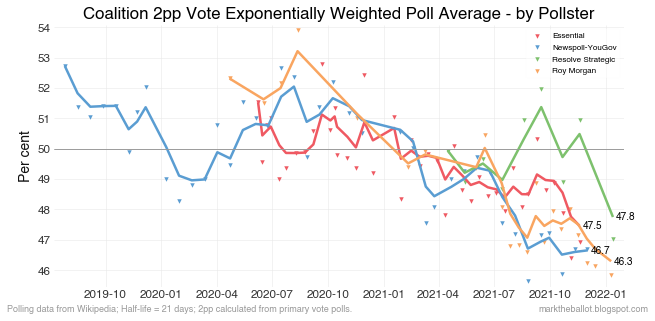

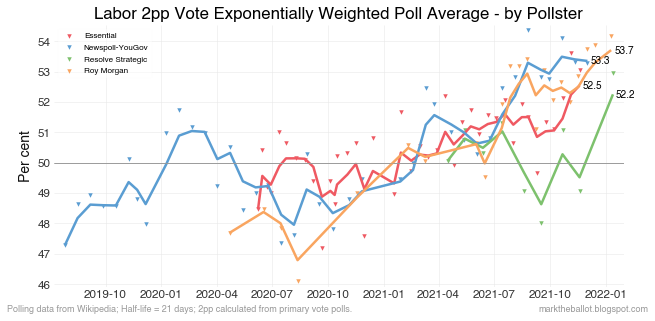

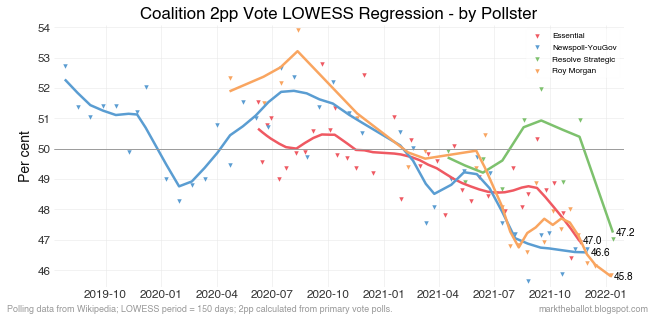

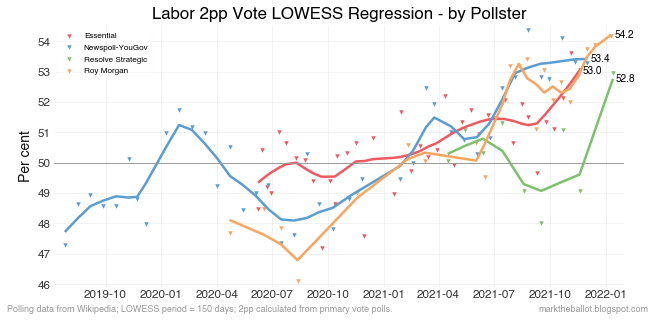

In [24]:
# 2pp ...
TPP_COLUMNS = ('Calculated 2pp L/NP', 'Calculated 2pp ALP')

llfooter = '; 2pp calculated from primary vote polls.'
for function, argument, stem, lfooter in zip(FUNCTIONS, ARGUMENTS, TITLE_STEMS, LFOOTERS):
    for party, column in zip(TPP_PARTIES, TPP_COLUMNS):
        title = f'{party} 2pp Vote {stem} - by Pollster'
        common.plot_summary_line_by_pollster(df=pv, 
                                      column=column, 
                                      title=title,
                                      function=function, 
                                      argument=argument, 
                                      lfooter=lfooter+llfooter)        


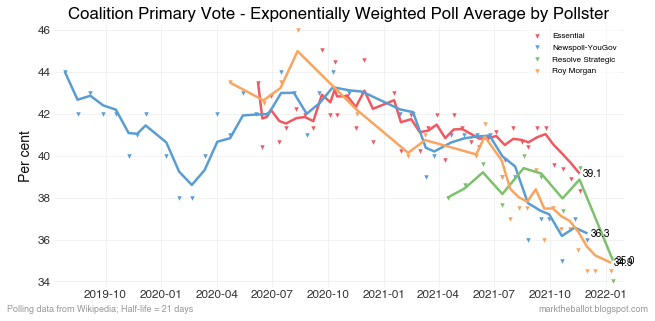

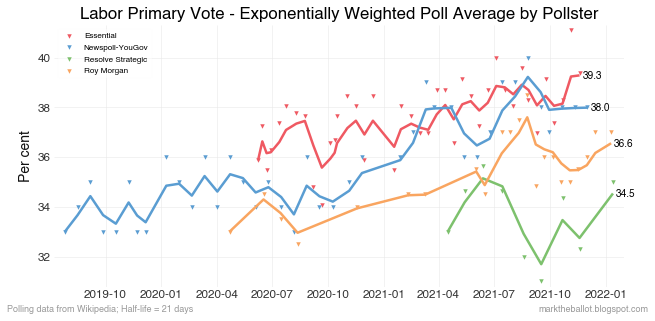

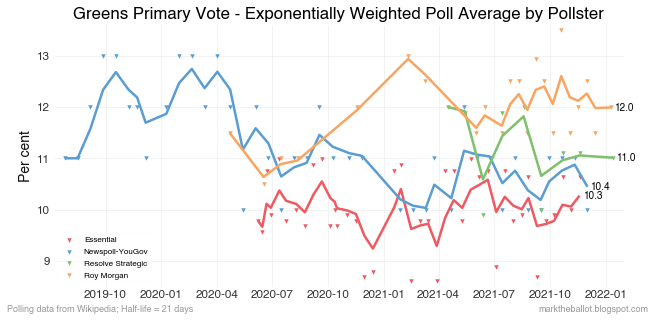

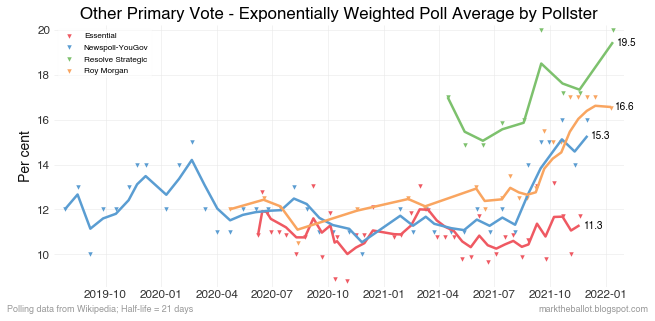

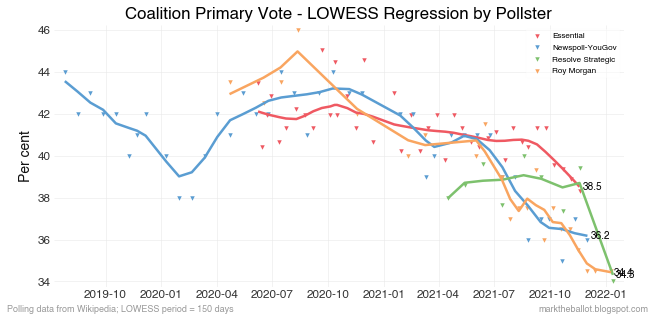

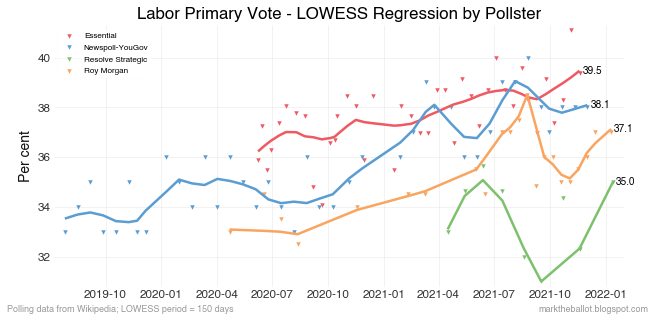

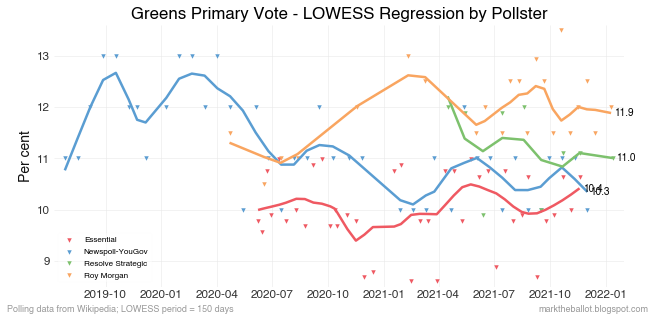

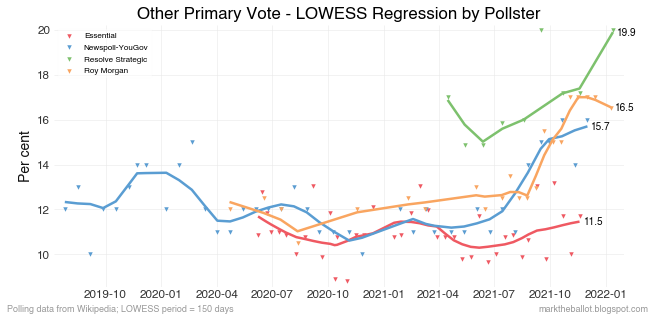

In [25]:
# primary votes ...
for function, argument, stem, lfooter in zip(FUNCTIONS, ARGUMENTS, TITLE_STEMS, LFOOTERS):
    for party, column in zip(PARTIES, COLUMNS):
        title = f'{party} Primary Vote - {stem} by Pollster'
        common.plot_summary_line_by_pollster(df=pv, 
                                      column=column, 
                                      title=title,
                                      function=function, 
                                      argument=argument, 
                                      lfooter=lfooter)        

### All poll aggregations

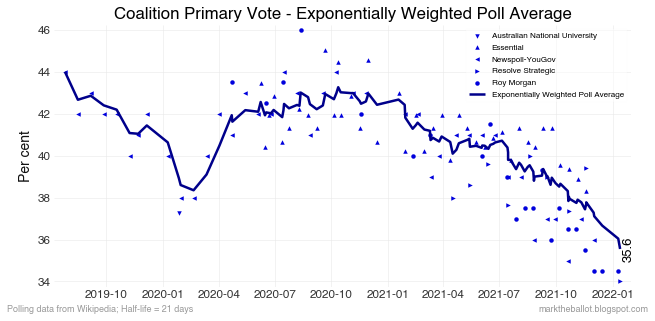

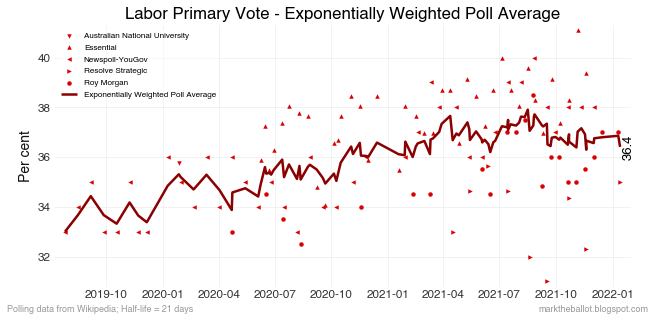

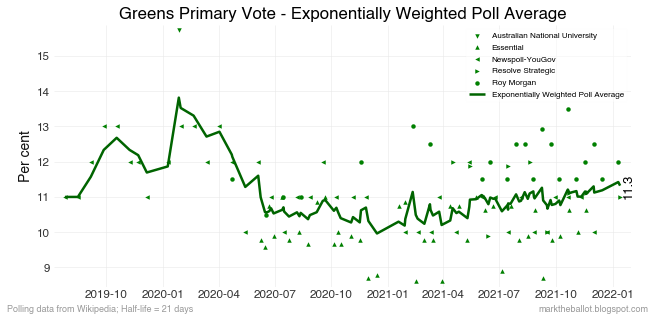

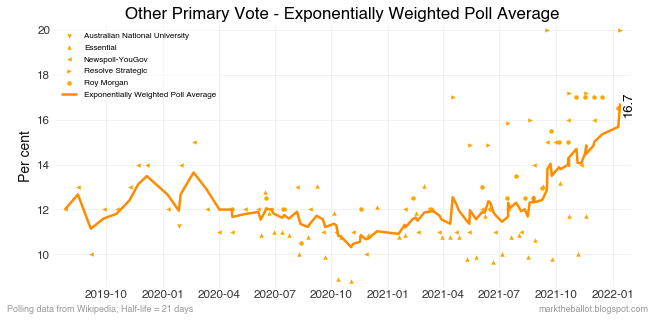

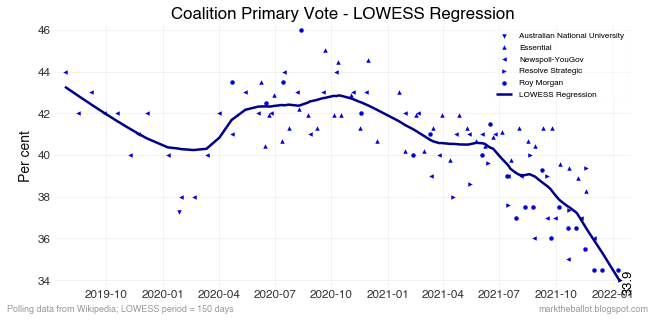

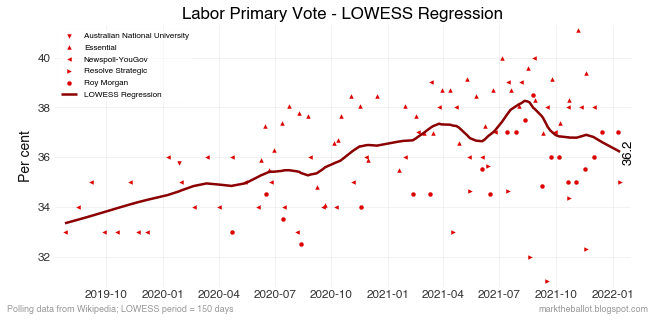

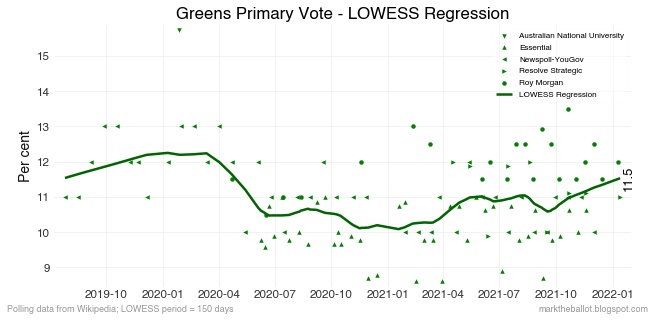

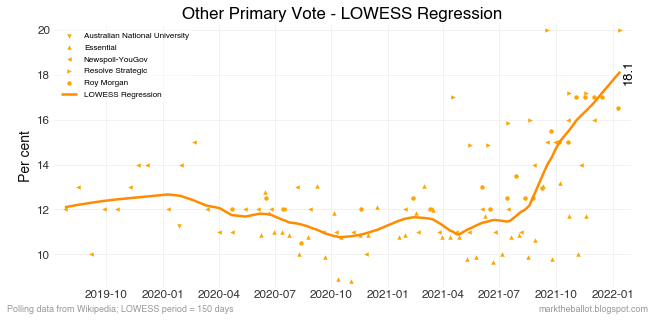

In [26]:
# primary votes ...
for function, argument, stem, lfooter in zip(FUNCTIONS, ARGUMENTS, TITLE_STEMS, LFOOTERS):
    for party, column, p_color, l_color in zip(PARTIES, COLUMNS, P_COLORS, L_COLORS):
        title = f'{party} Primary Vote - {stem}'
        common.plot_summary_line(df=pv, column=column, 
                      p_color=p_color, l_color=l_color, 
                      title=title,
                      function=function, 
                      argument=argument, 
                      label=stem, 
                      lfooter=lfooter)


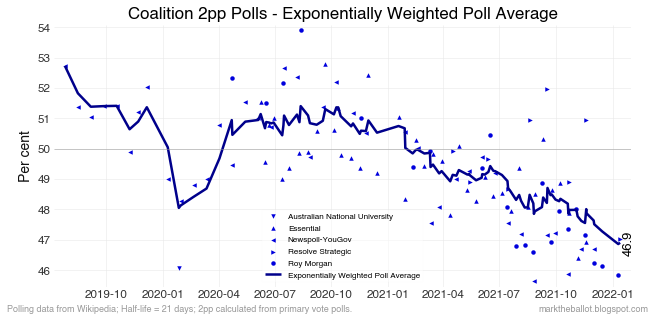

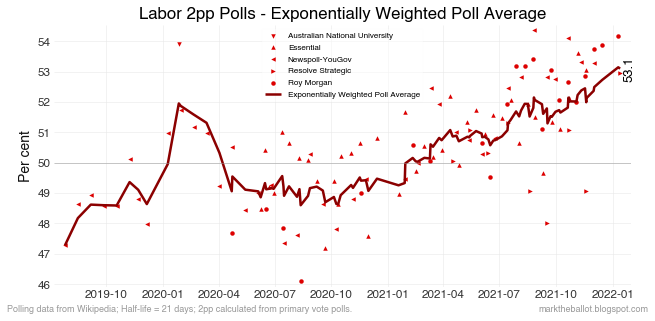

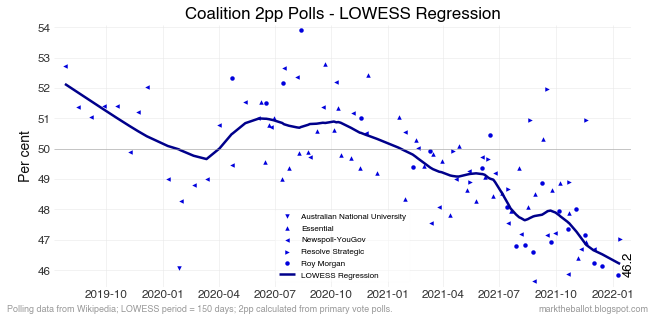

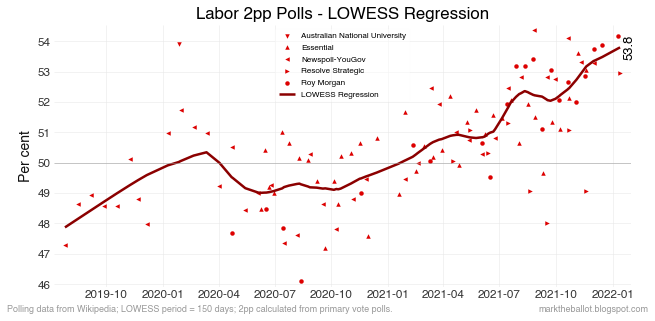

In [27]:
# 2pp, as calculated by me ...
TPP_COLUMNS = ('Calculated 2pp L/NP', 'Calculated 2pp ALP')
llfooter = '; 2pp calculated from primary vote polls.'

for function, argument, stem, lfooter in zip(FUNCTIONS, ARGUMENTS, TITLE_STEMS, LFOOTERS):
    for party, column, p_color, l_color in zip(TPP_PARTIES, TPP_COLUMNS, TPP_P_COLORS, TPP_L_COLORS):
        title = f'{party} 2pp Polls - {stem}'
        common.plot_summary_line(df=pv, column=column, 
                      p_color=p_color, l_color=l_color, 
                      title=title,
                      function=function, 
                      argument=argument, 
                      label=stem, 
                      lfooter=lfooter+llfooter)

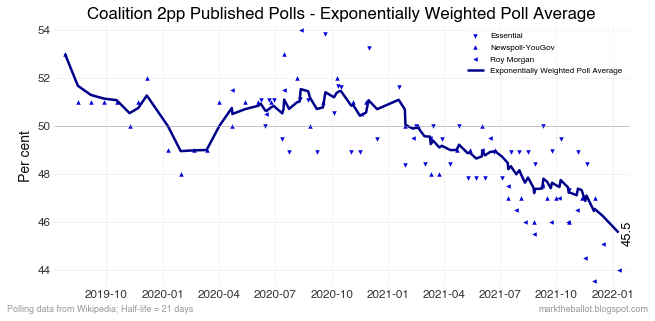

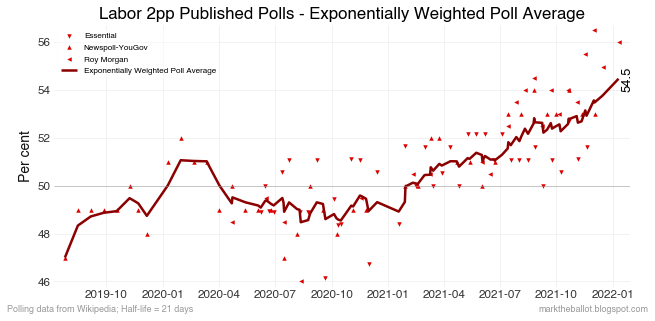

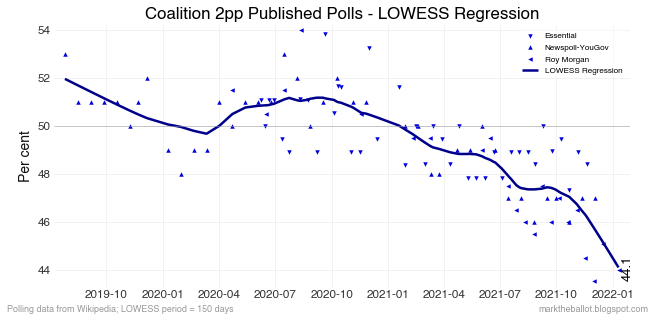

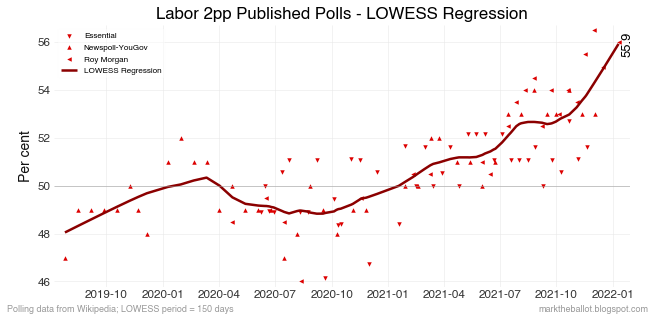

In [28]:
# 2pp, as published by pollsters ...
TPP_COLUMNS = ('2pp vote L/NP', '2pp vote ALP')

for function, argument, stem, lfooter in zip(FUNCTIONS, ARGUMENTS, TITLE_STEMS, LFOOTERS):
    for party, column, p_color, l_color in zip(TPP_PARTIES, TPP_COLUMNS, TPP_P_COLORS, TPP_L_COLORS):
        title = f'{party} 2pp Published Polls - {stem}'
        common.plot_summary_line(df=tpp, column=column, 
                      p_color=p_color, l_color=l_color, 
                      title=title,
                      function=function, 
                      argument=argument, 
                      label=stem, 
                      lfooter=lfooter)

### Preferred Prime Minister

In [29]:
ppm.columns

Index(['Mean Date', 'Date', 'Brand', 'Firm', 'Interview mode', 'Sample size',
       'Preferred Prime Minister Morrison',
       'Preferred Prime Minister Albanese',
       'Preferred Prime Minister Don't Know', 'Morrison Satisfied',
       'Morrison Dissatisfied', 'Morrison Don't Know', 'Albanese Satisfied',
       'Albanese Dissatisfied', 'Albanese Don't Know'],
      dtype='object')

In [30]:
def ppm_charts(df, columns, title):

    ax = None
    no_label = False
    fig, ax = common.initiate_plot()
    for col, (name, p_color, l_color) in columns.items():
        common.add_data_points_by_pollster(ax, df, col, p_color, no_label=no_label)
        no_label = True # avoid repeated labels
        lowess = common.calculate_lowess(ppm[col], ppm['Mean Date'], period=150)
        ax.plot(lowess.index, lowess, c=l_color, lw=2.5, label=name)
    common.add_h_refence(ax, reference=50)
    ax.legend(loc='best', ncol=2)
    common.plot_finalise(ax, ylabel='Per cent', title=title, lfooter=LFOOTER)

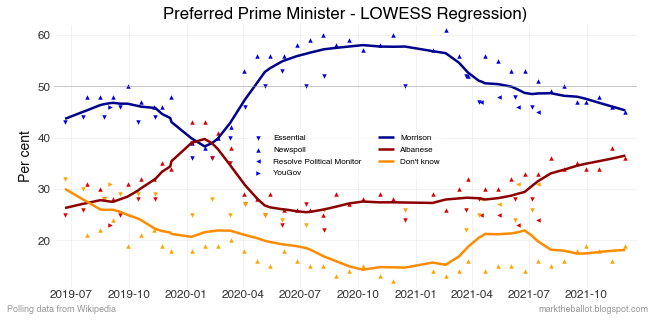

In [31]:
columns = {
    ('Preferred Prime Minister Morrison'): ['Morrison', P_COLOR_COALITION, COLOR_COALITION],    
    ('Preferred Prime Minister Albanese'): ['Albanese', P_COLOR_LABOR, COLOR_LABOR],    
    ("Preferred Prime Minister Don't Know"): ["Don't know", P_COLOR_OTHER, COLOR_OTHER],    
}

title = f'Preferred Prime Minister - LOWESS Regression)'
ppm_charts(ppm, columns, title)

### Satisfaction charts

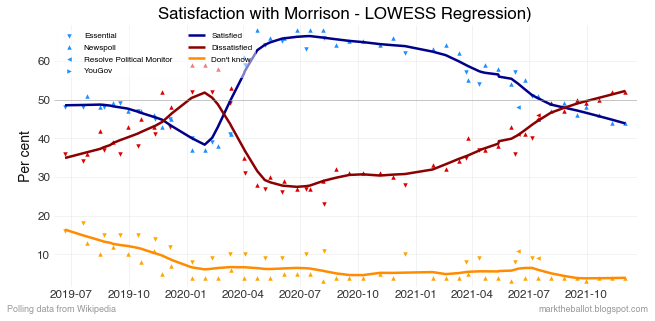

In [32]:
columns = {
    ('Morrison Satisfied'): ["Satisfied", 'dodgerblue', 'darkblue'],    
    ('Morrison Dissatisfied'): ["Dissatisfied", '#dd0000', 'darkred'],    
    ("Morrison Don't Know"): ["Don't know", 'orange', 'darkorange'],    
}

title = f'Satisfaction with Morrison - LOWESS Regression)'
ppm_charts(ppm, columns, title)

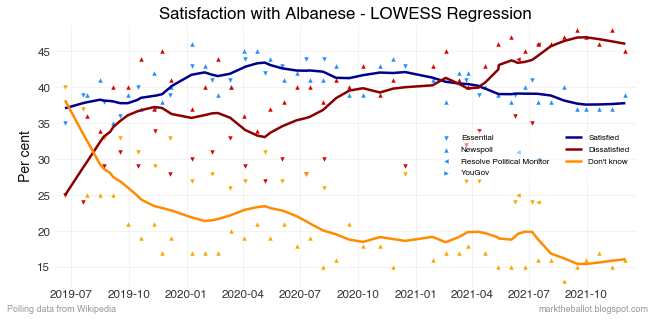

In [33]:
columns = {
    ('Albanese Satisfied'): ["Satisfied", 'dodgerblue', 'darkblue'],    
    ('Albanese Dissatisfied'): ["Dissatisfied", '#dd0000', 'darkred'],    
    ("Albanese Don't Know"): ["Don't know", 'orange', 'darkorange'],    
}

title = f'Satisfaction with Albanese - LOWESS Regression'
ppm_charts(ppm, columns, title)

## Save files

In [34]:
# and save to file
tpp.to_csv(f'{DATA_DIR}two_party_preferred.csv')
pv.to_csv(f'{DATA_DIR}primary_vote.csv')
ppm.to_csv(f'{DATA_DIR}preferred_prime_minister.csv')

## Check for any problems with data capture and cleaning

In [35]:
# Note you should go back and check any warnings that appear here ...
common.print_warnings()

  1: check_row_sums() found issues with Primary vote
  2: check_row_sums() found issues with Albanese
  3: final_sanity_check() found an issue with "2pp vote L/NP"
  4: final_sanity_check() found an issue with "2pp vote ALP"
  5: There is a substantial mismatch with pollster 2pp at
	[datetime.date(2021, 11, 17) datetime.date(2021, 12, 1)]
